Final Project Report: Predicting a High Contributer 
-

In [2]:
library(tidymodels)
library(tidyverse)
library(cowplot)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conf

## I. Introduction
#### Background:
Online gaming communities rely heavily on consistent player engagement to stay active, collaborative, and enjoyable. Some players are highly active and frequently participate in server-wide activities while other more casual players prefer to play or interact far less frequently. Understanding what factors influence a player's activity level can help developers improve user experience and strengthen player retention. In this project, we will be investigating how player characteristics such as age, experience, and subscription attribute to higher levels of engagement in the server. In our analysis, we will explore the dataset, `players.csv`, which contains information on player demographics, experience, engagement, and amount of time spent on the server. Our goal is to better understand the trends within this data and use these factors to build a predictive model which predicts whether a player is likely to be a high or low contributor to the server. 


#### Question:
Can player characteristics (specifically `experience`, `gender`, `subscribe`, and `Age`) predict whether a player is a high data contributor (defined as having `played_hours` in the top 75th percentile) in the `players` dataset?

#### Why `players.csv`?
Although the full dataset includes both `players.csv` and `sessions.csv`, the `players` dataset would be the best choice for our question. `sessions.csv` only contains information on individual play sessions with each row representing a session's player and duration of play. However, it does not include any player characteristics or demographics. Since our question of interest involves predicting which types of players are most likely to be high contributors based off player characteristics, we must use the dataset that actually contains these characteristics.


#### Data Description:
The `players` dataset contains data on player demographics, information, and engagement and has 196 observations and 7 variables.
| Variable Name |   Data Type   |                                 Meaning                                |
|:-------------:|:-------------:|:----------------------------------------------------------------------:|
|  experience   |   Character   |              A player’s self-reported experience level                 |
|  subscribe    |    Logical    |   Whether a player is subscribed to a game-related newsletter or not   |
|  hashedEmail  |   Character   |                             Hashed player email                        |
|  played_hours |    Double     |                      Total hours spent playing on server               |
|      name     |   Character   |                             Player's name                              |
|     gender    |   Character   |                            Player's gender                             |
|      Age      |    Double     |                        Player's age in years                           | 


#### Potential Issues:
- Most of the data in the `players` dataset comes from survey results so bias, exaggeration, or inaccuracy may be present.
- Missing values appear in some of the variables, including `gender` and `Age`
- The `experience` variable in `players.csv` is very subjective, and is more likely an indicator of how confident the player is, rather than an actual measure of their actual skill level.
- Most entries are less than `25 played_hours` with many zeroes, but there are several outliers that are well above 150. These outliers should be included in our analysis; however, they may make reading certain plots very difficult.
- `Age` could easily be fabricated.


## II. Methods & Results
#### Overall Process & Determining Which Variables to Use:
There are several variables available for building our KNN classification model, but it is important to thoroughly analyze each one to ensure it meets all assumptions required for KNN classification and whether it is relevant. To do this, we will do some exploratory analysis through visualizations. After selecting and deciding on the best predictors, we will then create a prediction model, using K-nearest neigbors, and evaluate its performance on the unseen test data using the optimal value for K.

First, we will need to view and load the datasets. Both appear to use a "," delimter, so read_csv will be the most appropriate option to use. 

In [3]:
players <- read_csv("https://raw.githubusercontent.com/Modas101/dsci-100-project-final/refs/heads/main/data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


There are some missing values in the `players` dataset, mainly in the `Age` variable. Since age is a predictor we intend to use, observations with missing age cannot be included. To classify players as *high contributors*, we defined a threshold: the top 25% of players would be considered as top contributors. We did some wrangling to calculate the minimum playtime to qualify as a high contributor and to create the `high_contributors` variable, labelling all players with playtime meeting or exceeding this threshold as high contributors. 

In [4]:
clean_players <- players |>
    filter(!is.na(Age))

played_hours_75th_percentile <- clean_players |>
    pull(played_hours) |>
    quantile(0.75)
played_hours_75th_percentile

clean_players <- clean_players |>
    mutate(high_contributor = played_hours > played_hours_75th_percentile)
head(clean_players)

75% 
0.6

experience,subscribe,hashedEmail,played_hours,name,gender,Age,high_contributor
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,TRUE
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,TRUE
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,FALSE
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,TRUE
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,FALSE
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,FALSE


We determined the mean hours played and the mean age of all players which are 5.9 hours and 21.14 years respectively. These values support the idea that the typical player in this dataset tend to be younger, with most in their late tens or early twenties, and confirm that most players in the dataset cannot be considered high contributors, as indicated by the relatively low average play time. 

In [14]:
mean_hours <- clean_players |>
  pull(played_hours) |>
  mean() |>
  round(2)
mean_hours

mean_age <- clean_players |>
  pull(Age) |>
  mean() |>
  round(2)
mean_age

[1] 5.9

[1] 21.14

We then plotted histograms showing the proportion of high-contribution players to `Age`, `experience`, and `subscribe`. These graphs help us visualize patterns present within the data, so we can choose which variables to include in our KNN classification model. 

Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_bar()`).”


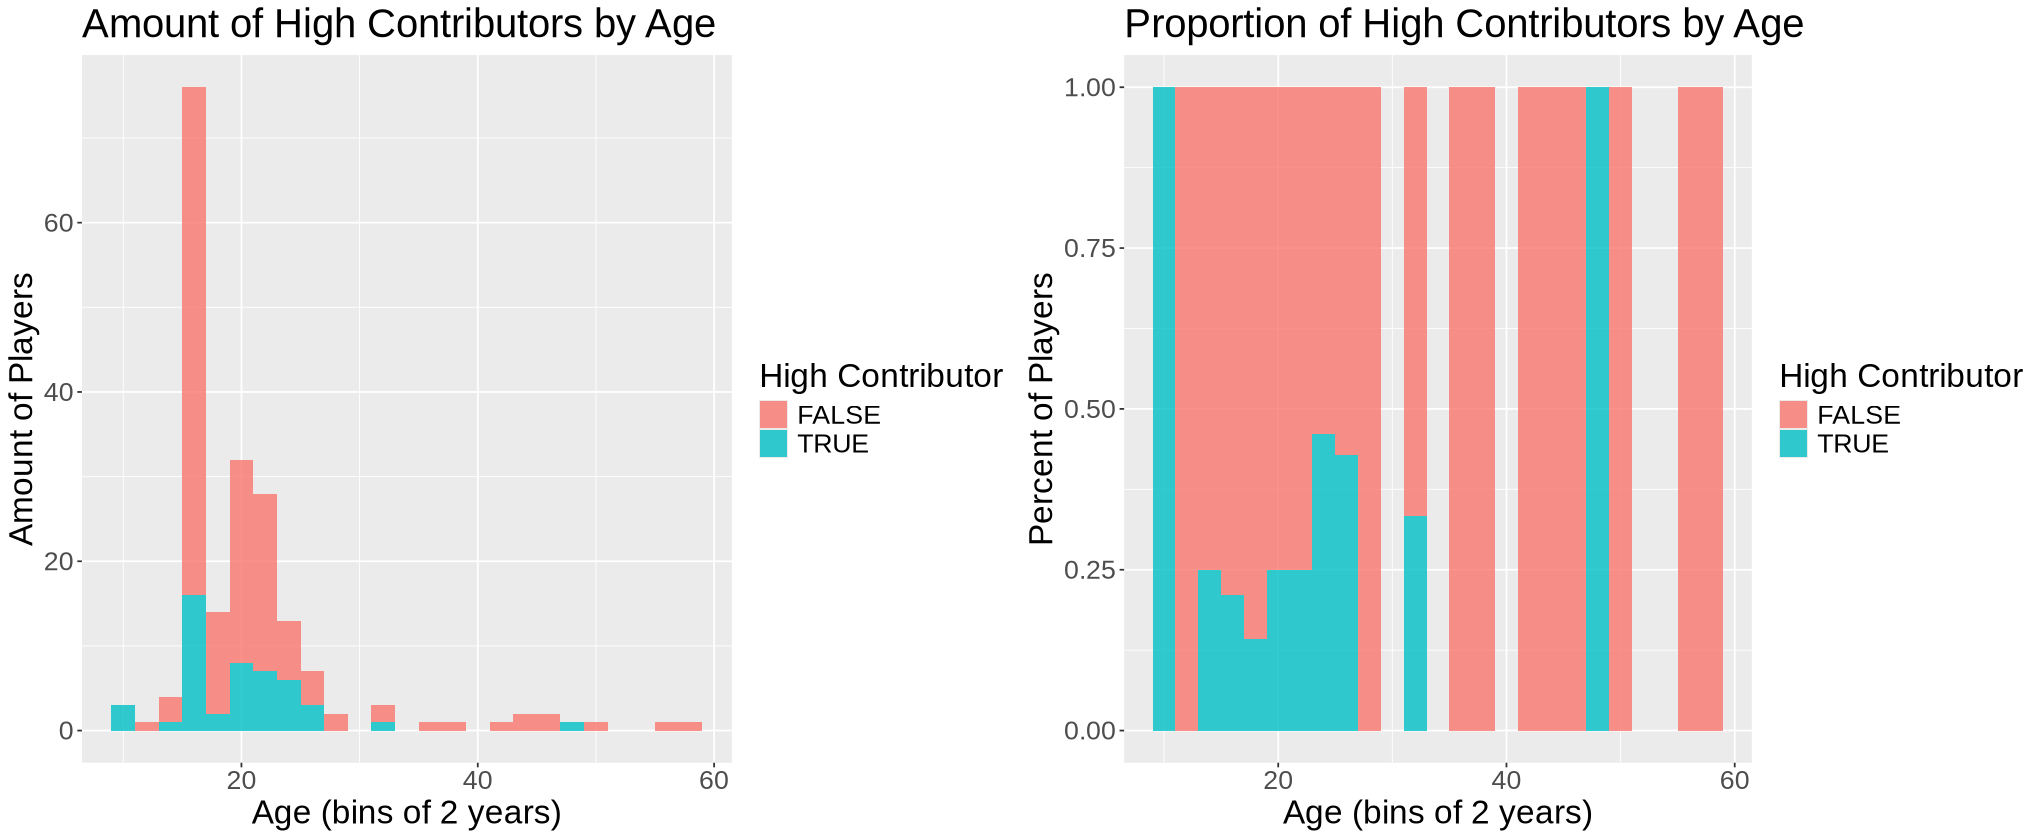

In [5]:
options(repr.plot.width = 17, repr.plot.height = 7)

amt_age_high_contrib <- clean_players |> 
    ggplot(aes(x = Age, fill = high_contributor)) +
        geom_histogram(binwidth = 2, position = "stack", alpha = 0.8) +
        labs(title = "Amount of High Contributors by Age",
            x = "Age (bins of 2 years)",
            y = "Amount of Players",
            fill = "High Contributor") + 
        theme(text = element_text(size = 20))
#amt_age_high_contrib

prop_age_high_contrib <- clean_players |> 
    ggplot(aes(x = Age, fill = high_contributor)) +
        geom_histogram(binwidth = 2, position = "fill", alpha = 0.8) +
        labs(title = "Proportion of High Contributors by Age",
            x = "Age (bins of 2 years)",
            y = "Percent of Players",
            fill = "High Contributor") + 
        theme(text = element_text(size = 20))
#prop_age_high_contrib

plot_grid(amt_age_high_contrib, prop_age_high_contrib)

The two graphs above show the amount and proportion of high contributors by age. The distribution appears to be far concentrated between younger ages (15-25 years old). Outside this range, older ages only appear a few times. Most of the high contributors also seem to be younger, representative of the higher number of younger players. 

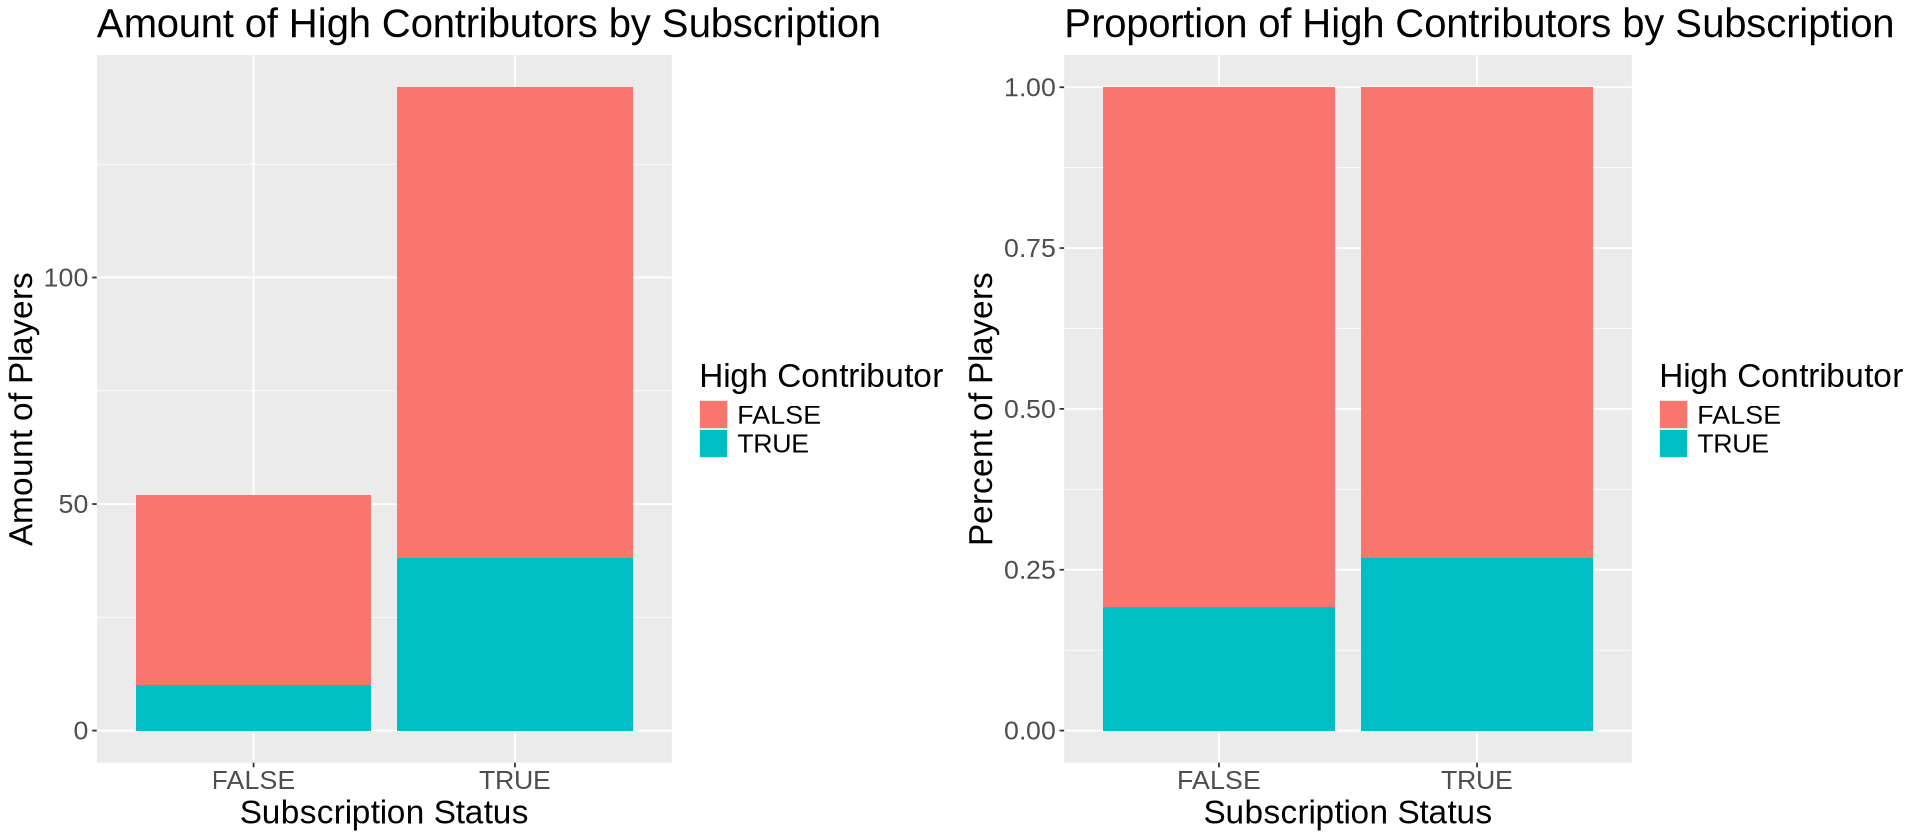

In [54]:
options(repr.plot.width = 16, repr.plot.height = 7)
amt_sub_high_contrib <- clean_players |> 
    ggplot(aes(x = subscribe, fill = high_contributor)) +
        geom_bar(position = "stack") +
        labs(title = "Amount of High Contributors by Subscription",
             x = "Subscription Status",
             y = "Amount of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

prop_sub_high_contrib <- clean_players |> 
    ggplot(aes(x = subscribe, fill = high_contributor)) +
        geom_bar(position = "fill") +
        labs(title = "Proportion of High Contributors by Subscription",
            x = "Subscription Status",
            y = "Percent of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

plot_grid(amt_sub_high_contrib, prop_sub_high_contrib)

The graphs above show the proportion and amount of high contributors for players subscribed to a game-related newsletter. It appears that more high contributors are subscribed, with a percentage of over 25% while non-subscribed players have a high contributor percentage of under 25%. 

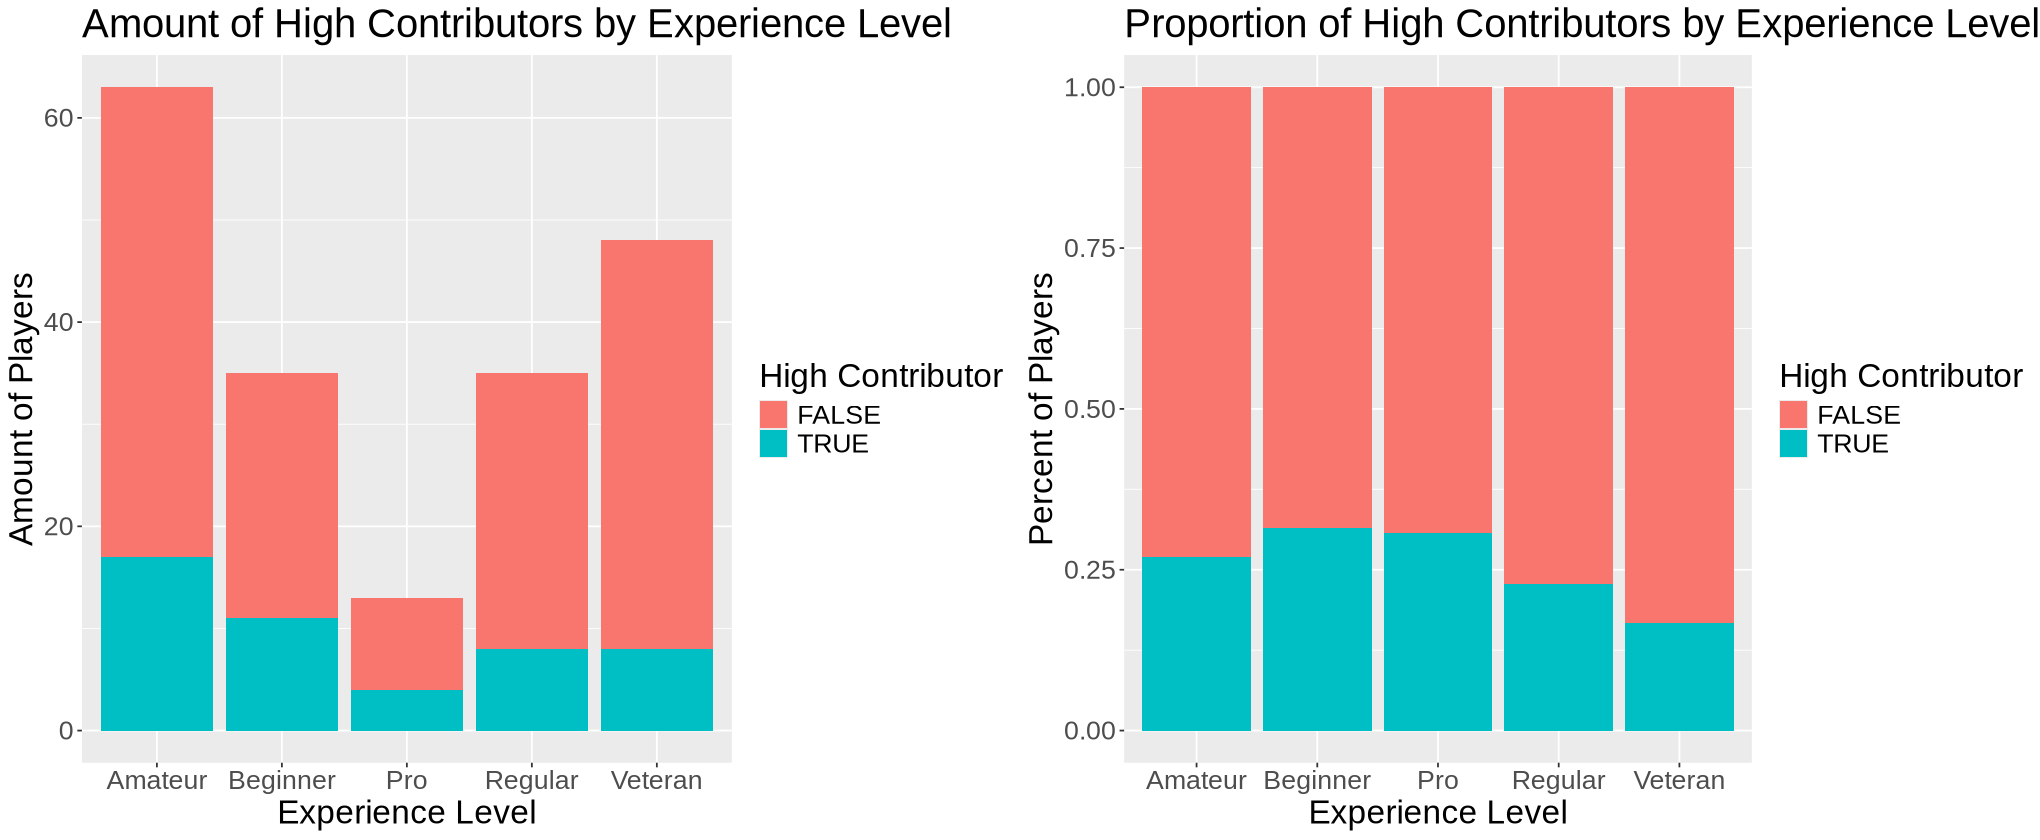

In [6]:
amt_exp_high_contrib <- clean_players |> 
    ggplot(aes(x = experience, fill = high_contributor)) +
        geom_bar(position = "stack") +
        labs(title = "Amount of High Contributors by Experience Level",
             x = "Experience Level",
             y = "Amount of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

prop_exp_high_contrib <- clean_players |> 
    ggplot(aes(x = experience, fill = high_contributor)) +
        geom_bar(position = "fill") +
        labs(title = "Proportion of High Contributors by Experience Level",
            x = "Experience Level",
            y = "Percent of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

plot_grid(amt_exp_high_contrib, prop_exp_high_contrib)

These two graphs show the proportion and amount of players who are considered high contributors within each experience level. Overall, Beginners and Pros appear to have the highest proportion of high contributors, while Amateurs and Beginners have the largest total-number of high-contributor players due to larger group sizes. One possible explanation for this may be that Beginner and Amateur players, with the least amount of experience, may be more curious or engaged as they explore the game. In contrast, Veteran and Pro players are already very familiar with the game and may have spent less time overall, resulting in fewer high contributors within those experience levels. 

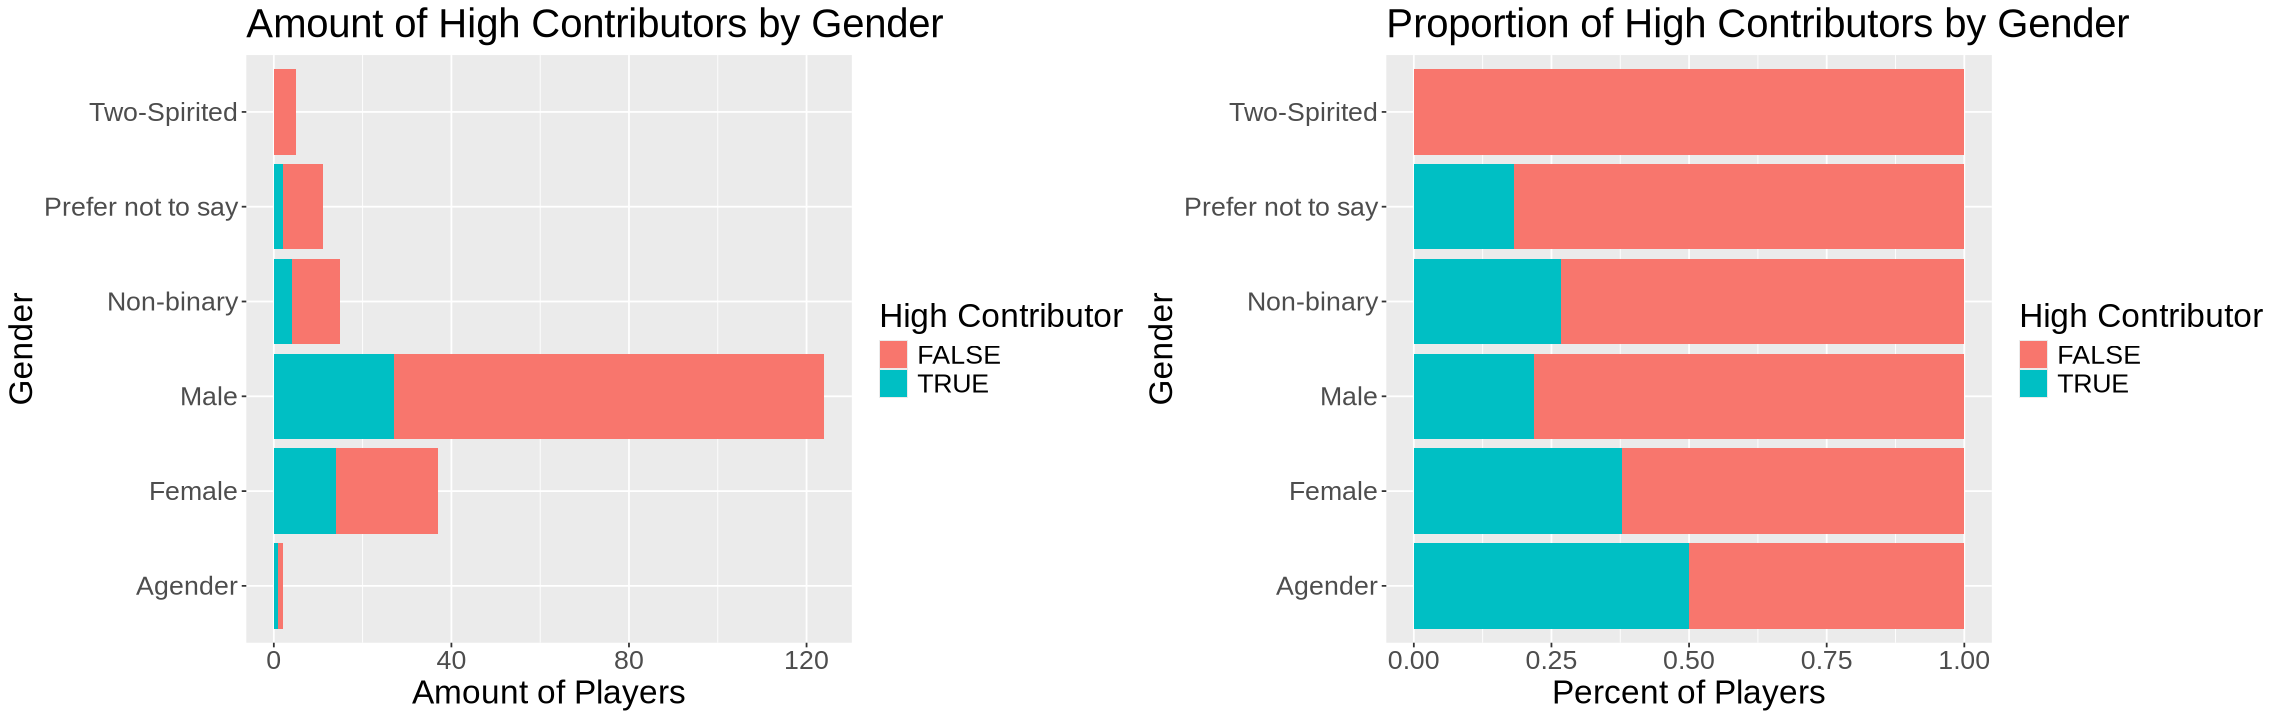

In [52]:
options(repr.plot.width = 19, repr.plot.height = 6)

amt_sub_high_contrib <- clean_players |> 
    ggplot(aes(y = gender, fill = high_contributor)) +
        geom_bar(position = "stack") +
        labs(title = "Amount of High Contributors by Gender",
            y = "Gender",
            x = "Amount of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

prop_sub_high_contrib <- clean_players |> 
    ggplot(aes(y = gender, fill = high_contributor)) +
        geom_bar(position = "fill") +
        labs(title = "Proportion of High Contributors by Gender",
            y = "Gender",
            x = "Percent of Players",
            fill = "High Contributor") +
        theme(text = element_text(size = 20))

plot_grid(amt_sub_high_contrib, prop_sub_high_contrib)

Shown above are two graphs that visualize the number and proportion of high contributors in each gender category. As expected, the Male gender category contains the largest number of players in the dataset, and therefore also has the largest count of high contributors. However, when looking at the proportion, the proportion of high contributors among male players  is actually one of the lowest among the all gender groups. 

All the variables appear to be reasonable predictors for high contributors, so we will include all of them in our model. Our goal is to determine the ideal K value, to avoid any of risk over or under-fitting the data. 

We begin by setting a seed to ensure the random splitting of our data is reproducible. Then, we will using a 75 - 25 split to determine the ideal K value. We seperated the data into training and testing sets, so that the model can be trained on one portion and and evaluated on unseen data to get a reliable estimate of its accuracy. Afterwards, we create a modeling recipe to preprocess and scale the data before fitting the KNN model. We then create a model specification, setting `neighbors = tune()` to determine the best K value. We combine these in a workflow. Finally, we create a 5-fold cross validation  and a data frame of possible K values from 1 to 20 that the model will try. 

In [58]:
model_data <- clean_players |>
    mutate(high_contributor = as.factor(high_contributor)) |>
    select(high_contributor, Age, experience, subscribe, gender)
head(model_data)

set.seed(123)

data_split <- initial_split(model_data, prop = 0.75, strata = high_contributor)

clean_players_training <- training(data_split)
clean_players_testing <- testing(data_split)

knn_recipe <- recipe(high_contributor~., data = clean_players_training) |>
    step_mutate(subscribe = as.integer(subscribe)) |>
    step_mutate(experience = case_match(experience,
        "Beginner" ~ 1,
        "Regular" ~ 2,
        "Amateur" ~ 3,
        "Veteran" ~ 4,
        "Pro" ~ 5)) |>
    step_novel(all_nominal_predictors()) |>
    step_dummy(all_nominal_predictors()) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_spec <- nearest_neighbor(neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

cv_folds <- vfold_cv(clean_players_training, v = 5, strata = high_contributor)

k_grid <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- knn_workflow |> 
    tune_grid(resamples = cv_folds, grid = k_grid) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(knn_results)

high_contributor,Age,experience,subscribe,gender
<fct>,<dbl>,<chr>,<lgl>,<chr>
TRUE,9,Pro,TRUE,Male
TRUE,17,Veteran,TRUE,Male
FALSE,17,Veteran,FALSE,Male
TRUE,21,Amateur,TRUE,Female
FALSE,21,Regular,TRUE,Male
FALSE,17,Amateur,TRUE,Female


→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_new.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x3

There were issues with some computations   A: x5





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7233005,5,0.03900000,Preprocessor1_Model01
2,accuracy,binary,0.7313793,5,0.02867672,Preprocessor1_Model02
3,accuracy,binary,0.7306897,5,0.04308413,Preprocessor1_Model03
4,accuracy,binary,0.7442365,5,0.02907923,Preprocessor1_Model04
5,accuracy,binary,0.7792118,5,0.02348178,Preprocessor1_Model05
6,accuracy,binary,0.7380624,5,0.04683476,Preprocessor1_Model06


We plotted possible ideal K values on a graph with its respective accuracy to determine the best K value to use. 

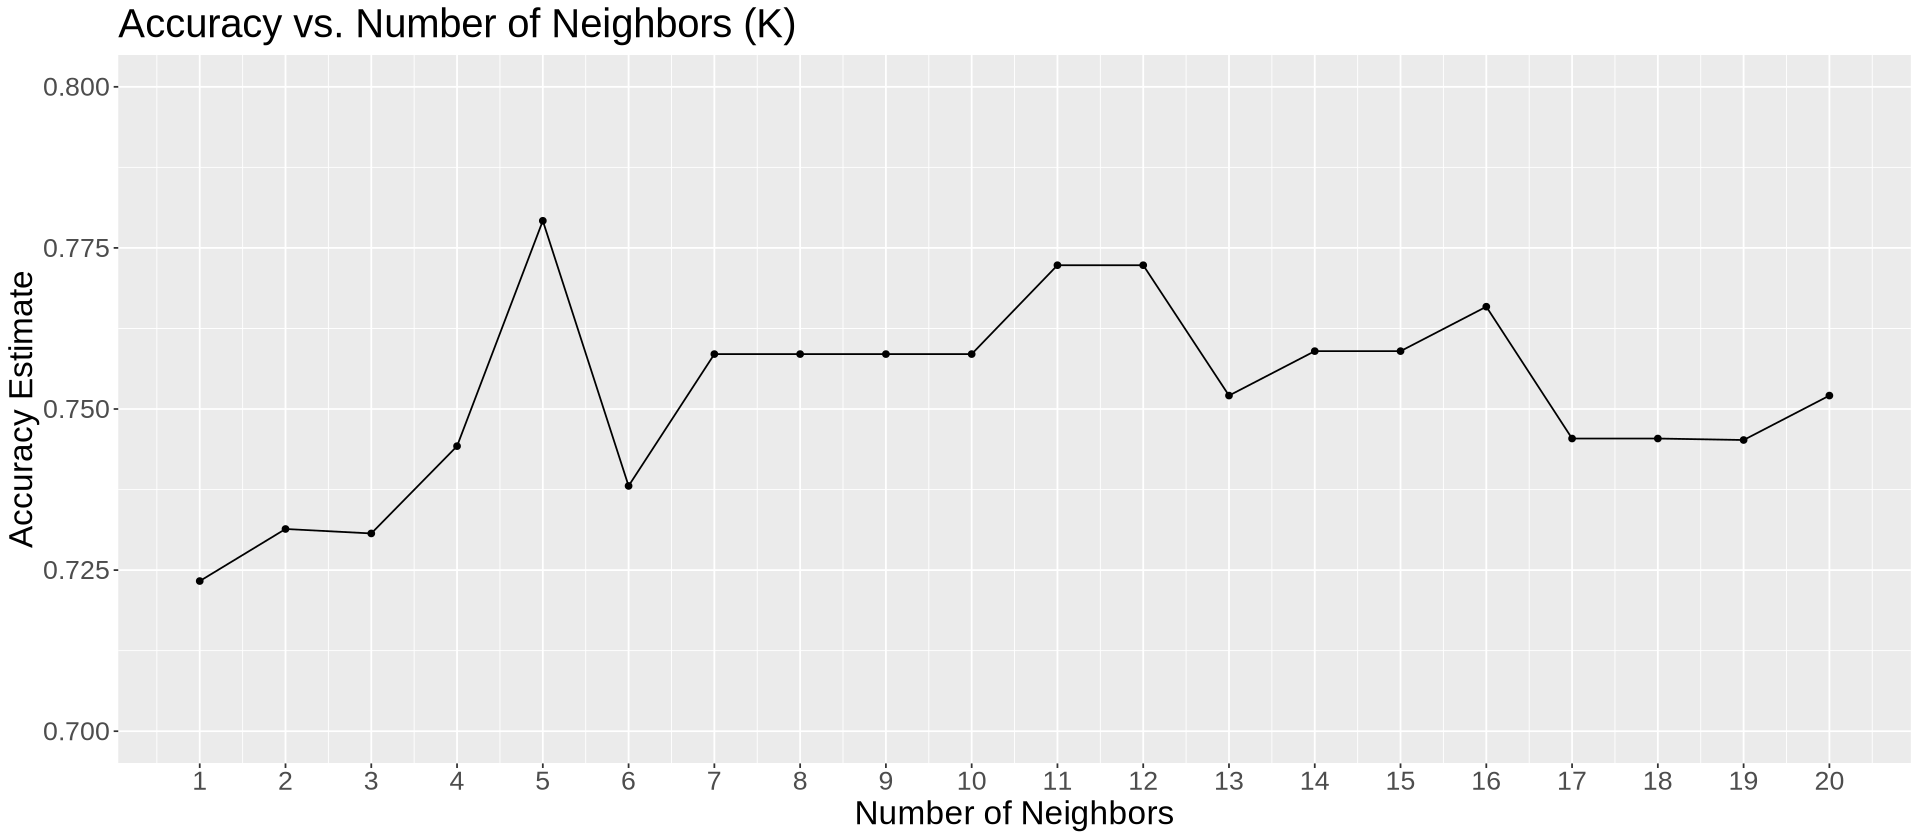

In [59]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors", y = "Accuracy Estimate", title = "Accuracy vs. Number of Neighbors (K)") + 
    scale_x_continuous(breaks = seq(1, 20, by = 1)) + # adjusting the x-axis 
    scale_y_continuous(limits = c(0.7, 0.8)) + # adjusting the y-axis 
    theme(text = element_text(size = 20)) 
accuracy_versus_k

The graph above shows how the estimated model accuracy changes as we change the number of neighbors (K) from 1 to 20. Accuracy increases from  `K = 1` to `K = 5`, where there is a spike. However, this appears to be an outlier as accuracy immediately drops after and does not show any similar behavior at any nearby K values. Beyond this point, the trend peaks around `K = 10-12`, with the maximums at `K = 11` and `K = 12`. After `K = 12`, the accuracy begins to decline again. Based on this, K = 11 appears to be the best K value with the highest accuracy. 

Finally, using the optimal K value of `K = 11`, we make a new model and fit it on the training data. We then use it to predict high contributors on the unseen testing set. We calculated the overall accuracy of our model on the testing data. These tests were run as many times as necessary until a sufficiently accurate model was generated. 

In [60]:
knn_best_spec <- nearest_neighbor(neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = clean_players_training)

knn_summary <- knn_best_fit |>
  predict(clean_players_testing) |>
  bind_cols(clean_players_testing) |>
  metrics(truth = high_contributor, estimate = .pred_class) |>
  filter(.metric == 'accuracy')

knn_summary

Warning message:
“!  The following column has zero variance so scaling cannot be used:
  gender_new.
ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
  before normalizing.”
Warning message:
“tune samples were requested but there were 145 rows in the data. 140 will be used.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


We evaluated the model on the test data and obtained an accuracy of 0.755102, meaning it correctly classified about 75.5% of the test observations. Although this result seems fairly high, it is important to recognize why the model achieved this value. Because only about 25% of players in the dataset are high contributors, the model that simply predicts “low contributor” for every player would already be correct roughly 75% of the time. Our model may be behaving similarly: it might be overwhelmingly predicting the majority class (“low”), which inflates accuracy without truly identifying high contributors. This suggests that the model is not truly identifying patterns in the predictors, but relying on in defaulting to predicting "low contributors" This could be due to several reasons. First, the dataset is relatively small, giving the model very limited information to learn from. With only around 196 observations and even fewer after removing missing values, the KNN model may struggle to recognize any trends. Second, the predictors we used (`Age`, `experience`, `subscription`, and `gender`) may not contain any consistent distinction that seperates the highest engagement players from everyone else.

## III. Discussion
In this project, we explored whether player characteristics (`Age`, `gender`, `experience`, and `subscribe`) could predict whether a player would be considered a high contributor, defined as as players with `played_hours` above the 75th percentile. Our exploratory visualization revealed several trends. High-contribution players tended to be younger, often in the late teens and early twenties. Players with greater experience and players subscribed to the newsletter were also more likely to be high contributors. 

When we trained a K-nearest neighbours classifier using `Age`, `experience`, `subscribe`, and `gender` to predict high contributors, we used cross-validation over `K = 1-20` to determine that the optimal K value is 11. With this K value, the final model achieved an accuracy of ~0.755 on the unseen test dataset. However, since only 25% of players are high contributors, simply predicting “low contributor” for every player would already reach around 75% accuracy. This suggests that the model we created cannot truly predict high contributors. This outcome is not unexpected given the limitations of the dataset, particularly the small sample size, and a no reliable correlation between the player characteristics and being a high contributor. Some preprocessing warning showed that there were columns with zero variance. However, this did not greatly affect model training, as the column labelled with zero varience, `gender_new`, was just a gender dummy variable. Categorical variables were properly encoded, and predictors were all centered and scaled so the distance-based calculations used by KNN would be as fair and comparable as possible. Despite these challenges, our findings did show the importance of data quality and balance when attempting to predict user engagement.

These results mostly alligned with what we expected given the limitations of the dataset. Before building the model, it was already clear that high contributors only made up a very small fraction of the players, so an imbalanced outcome was unavoidable. The final accuracy result of 75.5% is still relatively high. These findings show that models like this could be useful, but their effectiveness and reliability is limited by the quality and size of the data.

If developers or researchers were to build a more reliable predictive model, they would likely need a larger dataset with more detailed behavioral metrics as well as potentially using other approaches such as new methods of classification or regression. Overall, our analysis demonstrates that while KNN classification with the player characteristic variables were able to offer some insight into engagement patterns, some prediction these predictors alone are not strong enough to accurately distinguish high contributors from the rest of the player base. 